In [1]:
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import mixture

In [2]:
df = pd.read_csv('subscribers_new.csv')

In [3]:
df.head()

,Unnamed: 0,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,age,male_TF,...,join_fee,language,payment_type,num_trial_days,current_sub_TF,payment_period,last_payment,next_payment,cancel_date,trial_completed
0,162502,21724479,economy,NaN,comedy,access to exclusive content,NaN,NaN,NaN,False,...,NaN,ar,Standard Charter,14,True,1,2020-02-07 21:44:16,2020-06-07 21:44:16,NaN,True
1,380374,23383224,base,NaN,comedy,access to exclusive content,22.951579,NaN,70.0,False,...,0.3303,ar,NaN,14,True,1,2020-03-15 15:44:35,2020-07-15 15:44:35,NaN,True
2,496617,26844789,enhanced,3.0,regional,replace OTT,36.001186,2.0,25.0,True,...,0.1101,ar,NaN,14,False,0,NaN,NaN,NaN,True
3,356799,29417030,base,NaN,drama,replace OTT,20.051667,NaN,30.0,False,...,0.0367,ar,NaN,14,False,0,NaN,NaN,NaN,True
4,681701,26723159,base,4.0,comedy,replace OTT,22.951579,3.0,28.0,False,...,0.0367,ar,NaN,14,True,2,2020-02-19 12:57:07,2020-06-19 12:57:07,NaN,True


In [4]:
data = df.drop(columns = ['Unnamed: 0','language','country','months_per_bill_period',\
                            'language','last_payment','trial_end_date','monthly_price'])

In [250]:
#data = data[data['current_sub_TF'] == True]
#data['cancel_date'] = data['cancel_date'].fillna(0)
#data = data[data['cancel_date'] == 0]

In [251]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227628 entries, 0 to 227627
Data columns (total 23 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   package_type                  192054 non-null  object 
 1   num_weekly_services_utilized  117178 non-null  float64
 2   preferred_genre               191302 non-null  object 
 3   intended_use                  224079 non-null  object 
 4   weekly_consumption_hour       189698 non-null  float64
 5   num_ideal_streaming_services  115458 non-null  float64
 6   age                           192459 non-null  float64
 7   male_TF                       227359 non-null  object 
 8   attribution_technical         227628 non-null  object 
 9   attribution_survey            224984 non-null  object 
 10  op_sys                        214253 non-null  object 
 11  plan_type                     227628 non-null  object 
 12  discount_price                227628 non-nul

In [5]:
data4 = data[(data['weekly_consumption_hour']>0)&(data['join_fee']>0)]

In [6]:
data4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156919 entries, 1 to 227627
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   subid                         156919 non-null  int64  
 1   package_type                  130340 non-null  object 
 2   num_weekly_services_utilized  93599 non-null   float64
 3   preferred_genre               129611 non-null  object 
 4   intended_use                  155247 non-null  object 
 5   weekly_consumption_hour       156919 non-null  float64
 6   num_ideal_streaming_services  93311 non-null   float64
 7   age                           156919 non-null  float64
 8   male_TF                       156919 non-null  object 
 9   attribution_technical         156919 non-null  object 
 10  attribution_survey            156162 non-null  object 
 11  op_sys                        147174 non-null  object 
 12  plan_type                     156919 non-nul

In [7]:
data4['age_corrected'] = 0
for i in range(len(data4['age'])):
    a = data4['age'].values[i]
    if a > 1900 and a < 2020:
        data4['age_corrected'].values[i] = 2020-a
    else:
        data4['age_corrected'].values[i] = a

<ipython-input-7-0e851a6a1656>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data4['age_corrected'] = 0


In [8]:
data4 = data4[data4['age_corrected'] < 110]

In [9]:
data4['age_corrected'].values.mean()

46.078539406809384

In [10]:
data4 = data4.drop(columns = 'age')

In [11]:
c = float(data4['num_weekly_services_utilized'].dropna().mode().values)
d = float(data4['num_ideal_streaming_services'].dropna().mode().values)
data4['num_weekly_services_utilized'] = data4['num_weekly_services_utilized'].fillna(c)
data4['num_ideal_streaming_services'] = data4['num_ideal_streaming_services'].fillna(d)

In [12]:
data4['active days'] = ''
data4['cancel_date'] = data4['cancel_date'].fillna(0)
data4['next_payment'] = data4['next_payment'].fillna(0)

In [13]:
data4['account_creation_date']= pd.to_datetime(data4['account_creation_date'], format='%Y/%m/%d %H:%M')

In [14]:
for i in range(len(data4['account_creation_date'])):
    if data4['cancel_date'].values[i] == 0:
        pass
    else:
        data4['cancel_date'].values[i] = pd.to_datetime(data4['cancel_date'].values[i], format='%Y/%m/%d %H:%M')

In [15]:
for i in range(len(data4['account_creation_date'])):
    if data4['next_payment'].values[i] == 0:
        pass
    else:
        data4['next_payment'].values[i] = pd.to_datetime(data4['next_payment'].values[i], format='%Y/%m/%d %H:%M')

In [16]:
for i in range(len(data4['account_creation_date'])):
    a = data4['cancel_date'].values[i]
    b = data4['account_creation_date'].values[i]
    c = data4['next_payment'].values[i]
    if a == 0 and c != 0:
        data4['active days'].values[i] = (c-b).days
    elif a != 0:
        data4['active days'].values[i] = (a-b).days
    else:
        data4['active days'].values[i] = 14

In [17]:
data4['active days'] = data4['active days'].astype('int')

In [18]:
data4 = data4.drop(columns = ['account_creation_date','next_payment','cancel_date','payment_type'])

In [19]:
data4 = data4.drop(columns = ['num_trial_days','trial_completed','initial_credit_card_declined','plan_type'])

In [20]:
data4 = data4.drop(columns = 'attribution_technical')

In [21]:
data4 = data4.dropna()

In [22]:
data4 = data4[data4['age_corrected']>10]

In [23]:
data4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120733 entries, 2 to 227627
Data columns (total 16 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   subid                         120733 non-null  int64  
 1   package_type                  120733 non-null  object 
 2   num_weekly_services_utilized  120733 non-null  float64
 3   preferred_genre               120733 non-null  object 
 4   intended_use                  120733 non-null  object 
 5   weekly_consumption_hour       120733 non-null  float64
 6   num_ideal_streaming_services  120733 non-null  float64
 7   male_TF                       120733 non-null  object 
 8   attribution_survey            120733 non-null  object 
 9   op_sys                        120733 non-null  object 
 10  discount_price                120733 non-null  float64
 11  join_fee                      120733 non-null  float64
 12  current_sub_TF                120733 non-nul

In [25]:
data4_dummy = pd.get_dummies(data4)

In [26]:
cluster_train4, cluster_test4 = train_test_split(data4_dummy, test_size=0.3, random_state=777)
train_df4 = pd.DataFrame(cluster_train4, columns=data4_dummy.columns)
test_df4 = pd.DataFrame(cluster_test4, columns=data4_dummy.columns)

In [27]:
scaler = preprocessing.StandardScaler()
train_scaled4 = scaler.fit_transform(cluster_train4)
test_scaled4 = scaler.transform(cluster_test4)
full_scaled4 = scaler.transform(data4_dummy)

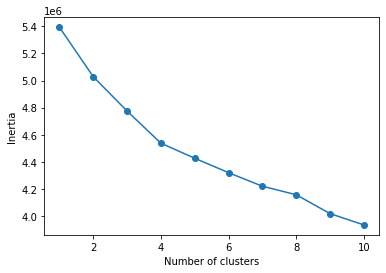

In [606]:
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='random', n_init=10, max_iter=200, tol=1e-04, random_state=777)
    kmeans.fit(full_scaled4)
    inertia.append(kmeans.inertia_)

# plot
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [29]:
from sklearn.mixture import GaussianMixture

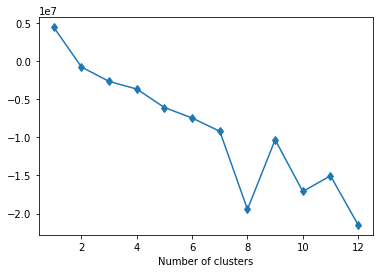

In [30]:
bic = []
for i in range(12):
    gm = GaussianMixture(
                     n_components = i+1,
                     covariance_type='full')
    
    gm.fit(full_scaled4)
    bic.append(gm.bic(full_scaled4))
    
fig = plt.figure()
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12], bic, marker = "d", label = 'bic')
plt.xlabel('Number of clusters')
plt.show()

In [609]:
kmeans = KMeans(n_clusters=4, init='random', n_init=10, max_iter=200, tol=1e-04, random_state=6868)
train_cluster_kmeans = kmeans.fit_predict(train_scaled4)
test_cluster_kmeans = kmeans.predict(test_scaled4)
full_cluster_kmeans = kmeans.predict(full_scaled4)

In [610]:
data_copy4 = data4
data_copy4['cluster_kmeans'] = full_cluster_kmeans
data_copy4.to_csv('Clustering Results_4.csv')

In [24]:
data4.to_csv('Clustering.csv')